<a href="https://colab.research.google.com/github/Kholis-Prasetya/Kholis-Prasetya.github.io/blob/master/predicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd


# Load the datasets
train_df = pd.read_csv('train.csv')
train_calendar_df = pd.read_csv('train_calendar.csv')
test_calendar_df = pd.read_csv('test_calendar.csv')

# Check for missing values in each dataframe
train_df.isnull().sum(), train_calendar_df.isnull().sum(), test_calendar_df.isnull().sum()


(warehouse                    0
 date                         0
 orders                       0
 holiday_name              7122
 holiday                      0
 shutdown                     0
 mini_shutdown                0
 shops_closed                 0
 winter_school_holidays       0
 school_holidays              0
 blackout                     0
 mov_change                   0
 frankfurt_shutdown           0
 precipitation              270
 snow                       270
 user_activity_1              0
 user_activity_2              0
 id                           0
 dtype: int64,
 date                          0
 holiday_name              12744
 holiday                       0
 shutdown                      0
 mini_shutdown                 0
 warehouse_limited             0
 shops_closed                  0
 winter_school_holidays        0
 school_holidays               0
 blackout                      0
 mov_change                    0
 frankfurt_shutdown            0
 precipitatio

In [3]:
# Fill missing values in train_df with appropriate methods (e.g., forward fill, mean imputation, etc.)
train_df.fillna(method='ffill', inplace=True)

# For train_calendar_df and test_calendar_df, if there are missing values, decide on a strategy to handle them
train_calendar_df.fillna(method='ffill', inplace=True)
test_calendar_df.fillna(method='ffill', inplace=True)


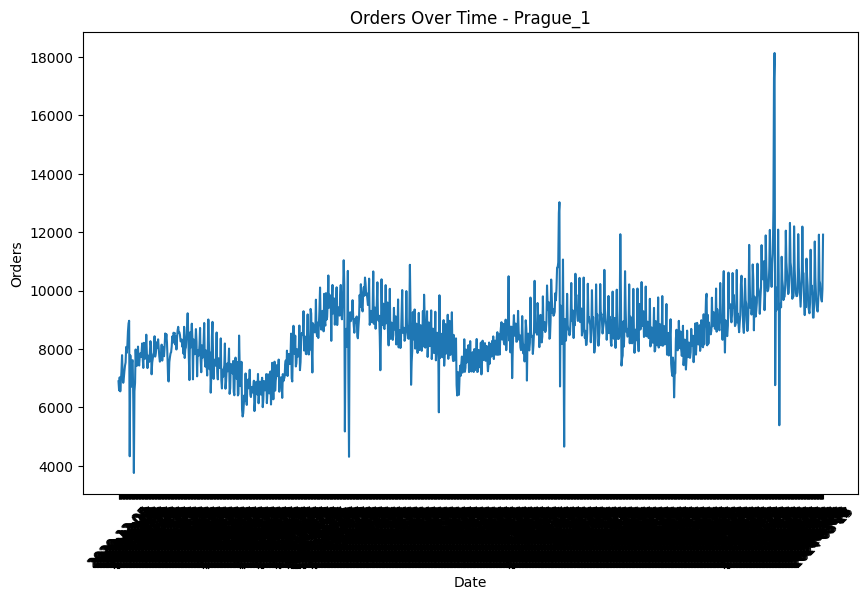

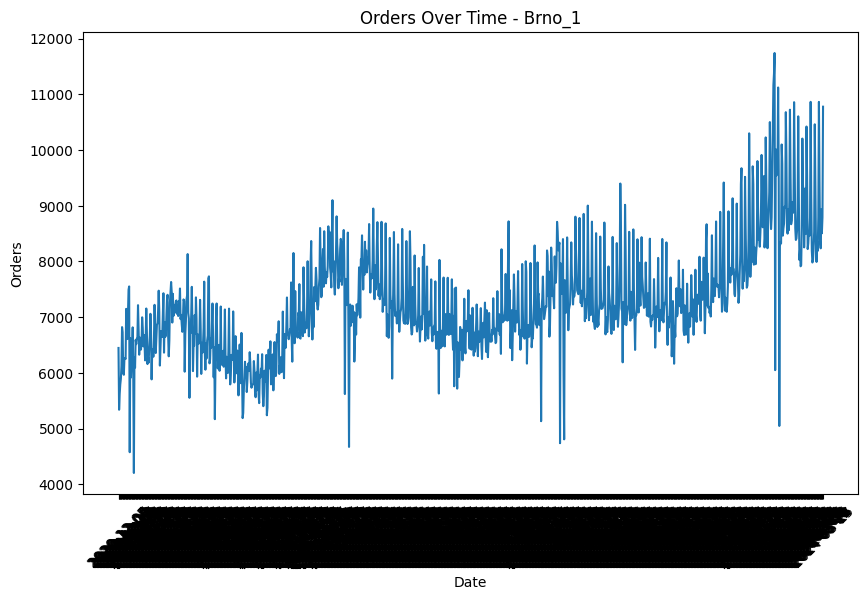

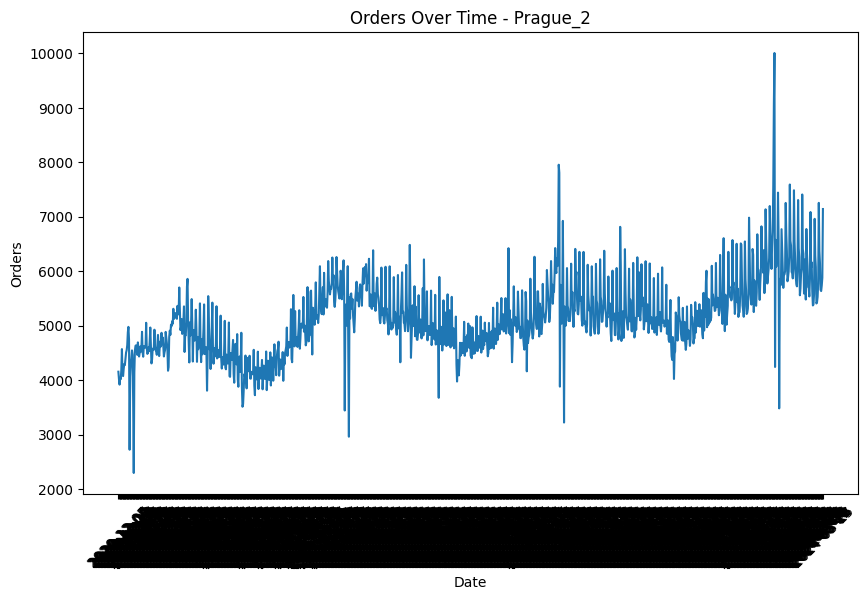

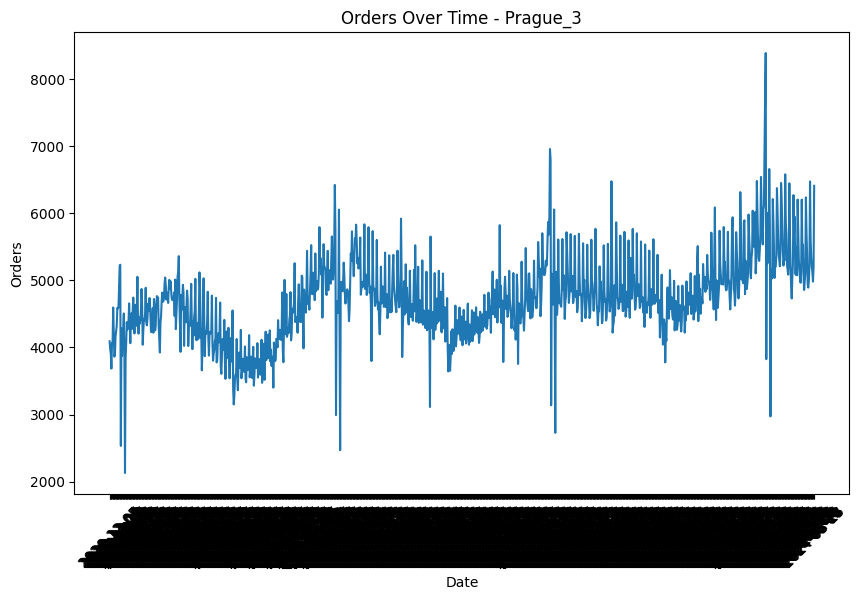

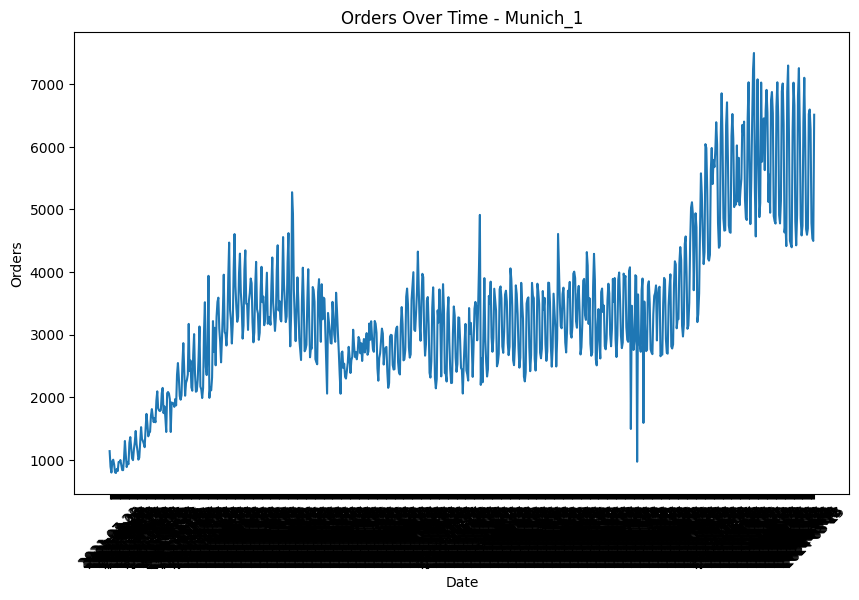

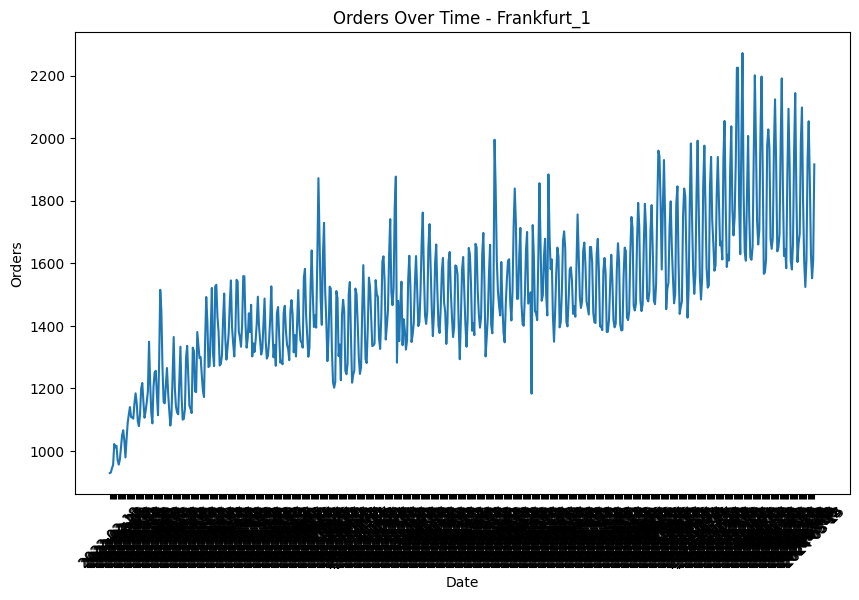

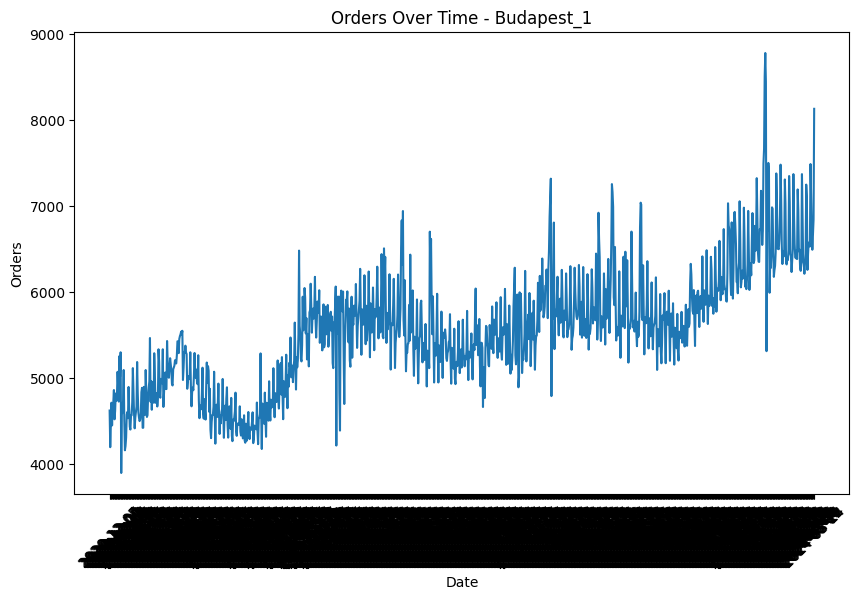

In [4]:
import matplotlib.pyplot as plt

# Plot the orders over time for each warehouse
for warehouse in train_df['warehouse'].unique():
    plt.figure(figsize=(10, 6))
    plt.plot(train_df[train_df['warehouse'] == warehouse]['date'], train_df[train_df['warehouse'] == warehouse]['orders'])
    plt.title(f'Orders Over Time - {warehouse}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.xticks(rotation=45)
    plt.show()


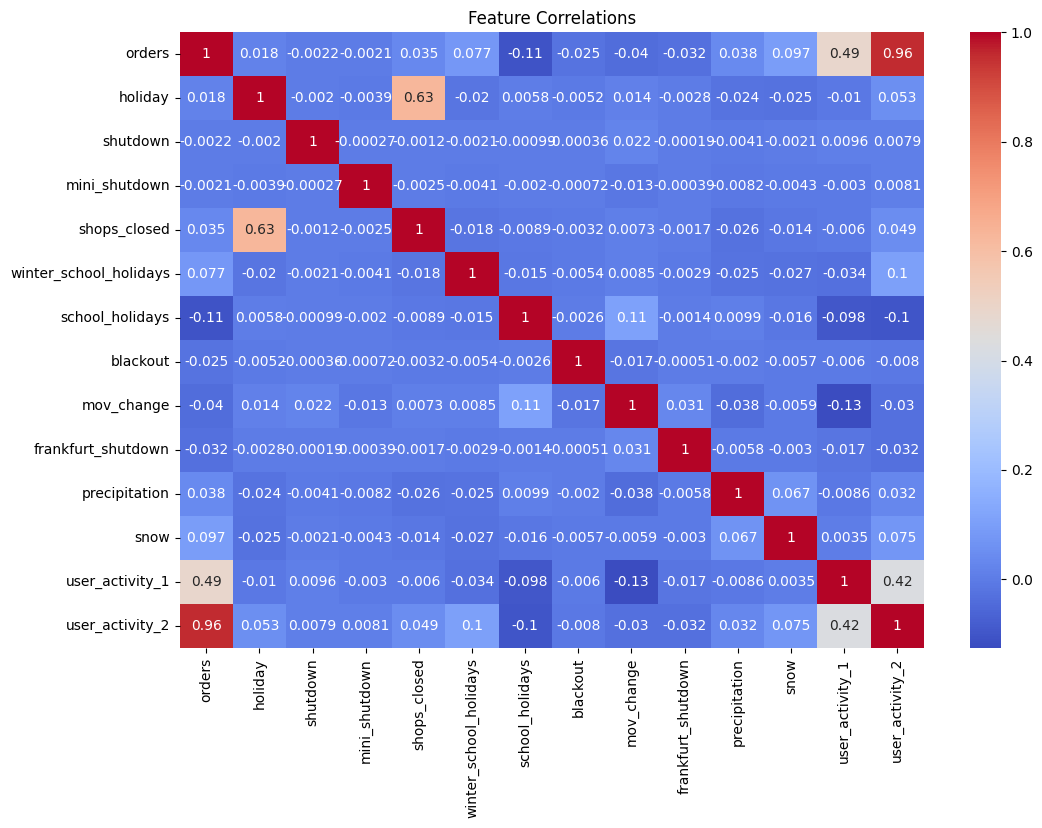

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlations excluding non-numeric columns
numeric_columns = train_df.select_dtypes(include=['number']).columns
correlations = train_df[numeric_columns].corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()



In [7]:
# Create lag features
for lag in range(1, 8):
    train_df[f'orders_lag_{lag}'] = train_df.groupby('warehouse')['orders'].shift(lag)

# Create rolling statistics
train_df['orders_rolling_mean_7'] = train_df.groupby('warehouse')['orders'].rolling(window=7).mean().reset_index(0, drop=True)

# Create date features
train_df['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek
train_df['month'] = pd.to_datetime(train_df['date']).dt.month


In [8]:
# Create lag features
for lag in range(1, 8):
    train_df[f'orders_lag_{lag}'] = train_df.groupby('warehouse')['orders'].shift(lag)

# Create rolling statistics
train_df['orders_rolling_mean_7'] = train_df.groupby('warehouse')['orders'].rolling(window=7).mean().reset_index(0, drop=True)

# Create date features
train_df['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek
train_df['month'] = pd.to_datetime(train_df['date']).dt.month


In [9]:
from sklearn.model_selection import train_test_split

# Define features and target
features = ['orders_lag_1', 'orders_lag_2', 'orders_lag_3', 'orders_lag_4', 'orders_lag_5', 'orders_lag_6', 'orders_lag_7', 'orders_rolling_mean_7', 'day_of_week', 'month']
target = 'orders'

# Drop rows with missing values created by lag features
train_df = train_df.dropna(subset=features)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f'Mean Absolute Percentage Error: {mape}')


Mean Absolute Percentage Error: 0.04379190016129542


In [16]:
import pandas as pd

# Load the test set
test_df = pd.read_csv('test.csv')

# Combine the train and test sets to ensure lag features are created correctly
combined_df = pd.concat([train_df[['warehouse', 'date', 'orders']], test_df[['warehouse', 'date']]], ignore_index=True)

# Sort by warehouse and date to maintain order
combined_df = combined_df.sort_values(by=['warehouse', 'date'])

# Create lag features
for lag in range(1, 8):
    combined_df[f'orders_lag_{lag}'] = combined_df.groupby('warehouse')['orders'].shift(lag)

# Create rolling statistics
combined_df['orders_rolling_mean_7'] = combined_df.groupby('warehouse')['orders'].rolling(window=7).mean().reset_index(0, drop=True)

# Create date features
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['day_of_week'] = combined_df['date'].dt.dayofweek
combined_df['month'] = combined_df['date'].dt.month

# Separate back into train and test sets
train_features_df = combined_df[combined_df['date'].isin(train_df['date'])]
test_features_df = combined_df[combined_df['date'].isin(test_df['date'])]

# Ensure there are no missing values in the features
test_features_df = test_features_df.dropna(subset=features)

# Predict orders for the test set
test_predictions = model.predict(test_features_df[features])

# Create the submission file
submission_df = test_features_df[['warehouse', 'date']].copy()
submission_df['ORDERS'] = test_predictions
submission_df['id'] = submission_df['warehouse'] + '_' + submission_df['date'].astype(str)
submission_df = submission_df[['id', 'ORDERS']]
submission_df.to_csv('submission.csv', index=False)


ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required by RandomForestRegressor.

In [17]:
import pandas as pd

# Load the test set
test_df = pd.read_csv('test.csv')

# Combine the train and test sets to ensure lag features are created correctly
combined_df = pd.concat([train_df[['warehouse', 'date', 'orders']], test_df[['warehouse', 'date']]], ignore_index=True)

# Sort by warehouse and date to maintain order
combined_df = combined_df.sort_values(by=['warehouse', 'date'])

# Create lag features
for lag in range(1, 8):
    combined_df[f'orders_lag_{lag}'] = combined_df.groupby('warehouse')['orders'].shift(lag)

# Create rolling statistics
combined_df['orders_rolling_mean_7'] = combined_df.groupby('warehouse')['orders'].rolling(window=7).mean().reset_index(0, drop=True)

# Create date features
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['day_of_week'] = combined_df['date'].dt.dayofweek
combined_df['month'] = combined_df['date'].dt.month

# Separate back into train and test sets
train_features_df = combined_df[combined_df['date'].isin(train_df['date'])]
test_features_df = combined_df[combined_df['date'].isin(test_df['date'])]

# Instead of dropping rows with missing values, fill them with a suitable value (e.g., 0)
test_features_df = test_features_df.fillna(0)  # Fill missing values with 0

# Predict orders for the test set
test_predictions = model.predict(test_features_df[features])

# Create the submission file
submission_df = test_features_df[['warehouse', 'date']].copy()
submission_df['ORDERS'] = test_predictions
submission_df['id'] = submission_df['warehouse'] + '_' + submission_df['date'].astype(str)
submission_df = submission_df[['id', 'ORDERS']]
submission_df.to_csv('submission.csv', index=False)